# Phase35 UC-6 DR Estimate

## Setup

In [1]:
from __future__ import annotations

import json
from datetime import datetime, timezone
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Image, display

from veldra.api import estimate_dr, evaluate, fit, tune
from veldra.api.artifact import Artifact
from veldra.diagnostics import (
    binary_metrics,
    build_binary_table,
    build_dr_table,
    build_drdid_table,
    build_frontier_table,
    build_multiclass_table,
    build_regression_table,
    compute_balance_smd,
    compute_importance,
    compute_overlap_stats,
    compute_shap,
    compute_shap_multiclass,
    frontier_metrics,
    multiclass_metrics,
    plot_confusion_matrix,
    plot_error_histogram,
    plot_feature_importance,
    plot_frontier_scatter,
    plot_if_distribution,
    plot_learning_curve,
    plot_love_plot,
    plot_parallel_trends,
    plot_pinball_histogram,
    plot_propensity_distribution,
    plot_roc_comparison,
    plot_roc_multiclass,
    plot_shap_summary,
    plot_timeseries_prediction,
    plot_timeseries_residual,
    plot_weight_distribution,
    regression_metrics,
)

ROOT = Path('.').resolve()
OUT_DIR = ROOT / 'examples' / 'out' / 'phase35_uc06_dr_estimate'
OUT_DIR.mkdir(parents=True, exist_ok=True)
diag_dir = OUT_DIR / 'diagnostics'
diag_dir.mkdir(parents=True, exist_ok=True)
UC_ID = 'UC-6'


/home/rem/repos/VeldraML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation

In [2]:
source_df = pd.read_csv(ROOT / 'data' / 'lalonde.csv')
source_path = OUT_DIR / 'lalonde.csv'
source_df.to_csv(source_path, index=False)
target_col = 'outcome'
treatment_col = 'treatment'


## 2. Feature Selection

In [3]:
covariate_cols = [col for col in source_df.columns if col not in {target_col, treatment_col}]
if not covariate_cols:
    raise ValueError('No covariate columns found for DR estimation.')
covariates = source_df.loc[:, covariate_cols].reset_index(drop=True)


## 3. Config

In [4]:
config = {
    'config_version': 1,
    'task': {'type': 'regression'},
    'data': {
        'path': str(source_path),
        'target': target_col,
    },
    'split': {'type': 'kfold', 'n_splits': 4, 'seed': 42},
    'train': {
        'seed': 42,
        'num_boost_round': 1200,
        'early_stopping_rounds': 120,
        'early_stopping_validation_fraction': 0.2,
        'auto_num_leaves': True,
        'num_leaves_ratio': 1.0,
        'min_data_in_leaf_ratio': 0.01,
        'min_data_in_bin_ratio': 0.01,
        'metrics': ['rmse', 'mae'],
        'lgb_params': {
            'learning_rate': 0.02,
            'max_depth': 10,
            'feature_fraction': 1.0,
            'bagging_fraction': 1.0,
            'bagging_freq': 0,
            'lambda_l1': 0.0,
            'lambda_l2': 0.000001,
            'first_metric_only': True,
        },
    },
    'causal': {
        'method': 'dr',
        'treatment_col': treatment_col,
        'estimand': 'att',
    },
    'export': {'artifact_dir': str(OUT_DIR / 'artifacts')},
}


## 4. Run Estimation

In [5]:
result = estimate_dr(config)
obs_df = pd.read_parquet(result.metadata['observation_path'])


## 5. Metrics Summary

In [6]:
overlap_stats = compute_overlap_stats(
    obs_df['e_hat'].to_numpy(dtype=float),
    obs_df['treatment'].to_numpy(dtype=int),
)
metrics_df = pd.DataFrame(
    [
        {
            'label': 'dr_att',
            'estimate': result.estimate,
            'std_error': result.std_error,
            'ci_lower': result.ci_lower,
            'ci_upper': result.ci_upper,
            'overlap_metric': result.metrics.get('overlap_metric'),
            'smd_max_unweighted': result.metrics.get('smd_max_unweighted'),
            'smd_max_weighted': result.metrics.get('smd_max_weighted'),
            **overlap_stats,
        }
    ]
)
metrics_path = OUT_DIR / 'metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
display(metrics_df)


,label,estimate,std_error,ci_lower,ci_upper,overlap_metric,smd_max_unweighted,smd_max_weighted,min,max,p01,p99,extreme_ratio
0,dr_att,1.654466,0.172073,1.317203,1.99173,1.0,0.467935,0.383053,0.403163,0.562452,0.405171,0.561399,0.0


## 6. DR Table

In [7]:
dr_table = build_dr_table(obs_df)
dr_table_path = OUT_DIR / 'dr_table.csv'
dr_table.to_csv(dr_table_path, index=False)
display(dr_table.head(10))


,treatment,outcome,e_raw,e_hat,m1_hat,m0_hat,psi,weight
0,0,1.782333,0.403946,0.458890,3.108079,1.427481,-0.637270,-1.795874
1,1,5.819997,0.549981,0.490459,5.749138,3.669551,4.553886,2.117647
2,0,1.730061,0.170080,0.409113,3.108079,1.427481,-0.443643,-1.466200
3,0,3.149167,0.657056,0.513670,6.057348,3.932217,1.751440,-2.236692
4,1,4.142770,0.596196,0.500478,4.539416,3.825942,0.670929,2.117647
5,0,3.175759,0.405766,0.459281,3.716132,2.347045,-1.490617,-1.798710
6,0,1.580290,0.185775,0.412408,2.056161,1.136791,-0.659170,-1.486293
7,1,4.294355,0.547357,0.489891,5.140847,3.329463,2.043301,2.117647
8,1,2.623410,0.160039,0.407010,3.215295,1.305498,2.790872,2.117647
9,0,-0.503685,0.516514,0.483209,2.102751,0.379664,1.749061,-1.980035


## 7. Balance Table

In [8]:
smd_unweighted = compute_balance_smd(covariates, source_df[treatment_col])
smd_weighted = compute_balance_smd(covariates, source_df[treatment_col], obs_df['weight'])
balance_df = smd_unweighted.merge(
    smd_weighted,
    on='feature',
    suffixes=('_unweighted', '_weighted'),
    how='outer',
)
balance_path = OUT_DIR / 'balance_smd.csv'
balance_df.to_csv(balance_path, index=False)
display(balance_df)


,feature,smd_unweighted,smd_weighted
0,x1,0.467935,0.383053
1,x2,0.288215,0.221688


## 8. Influence Function Distribution

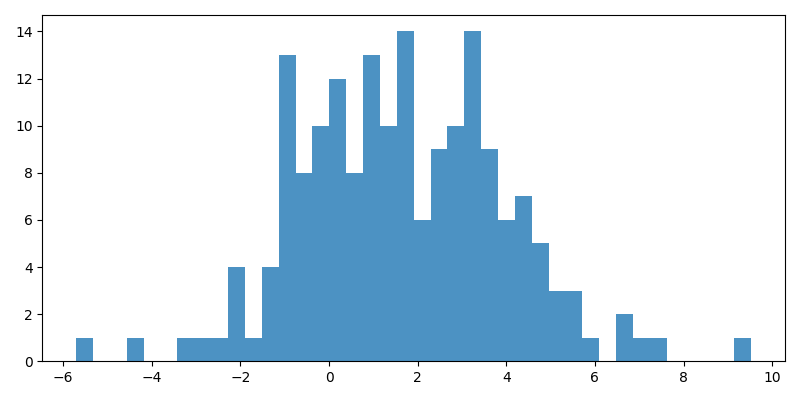

In [9]:
if_path = diag_dir / 'if_distribution.png'
plot_if_distribution(obs_df['psi'].to_numpy(dtype=float), if_path)
display(Image(filename=str(if_path)))


## 9. Propensity Distribution

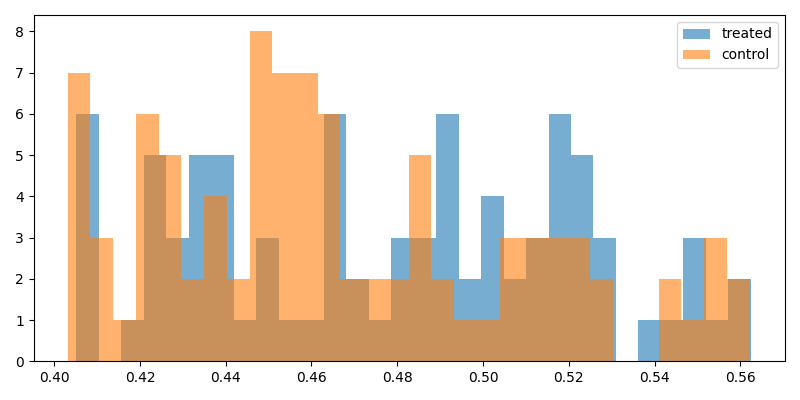

In [10]:
prop_path = diag_dir / 'propensity_distribution.png'
plot_propensity_distribution(
    obs_df['e_hat'].to_numpy(dtype=float),
    obs_df['treatment'].to_numpy(dtype=int),
    prop_path,
)
display(Image(filename=str(prop_path)))


## 10. Weight Distribution

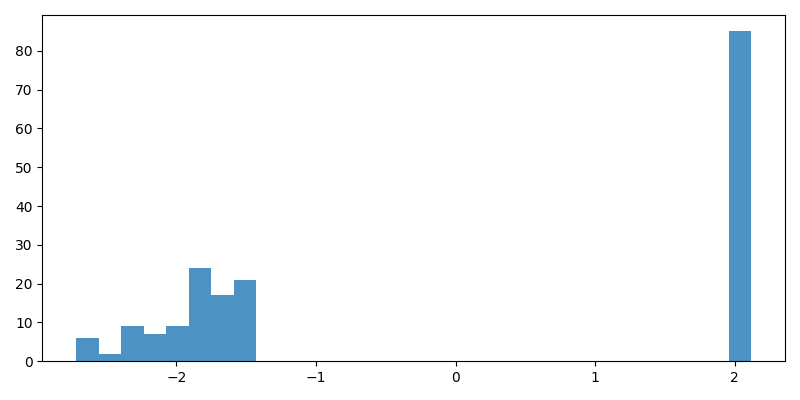

In [11]:
weight_path = diag_dir / 'weight_distribution.png'
plot_weight_distribution(obs_df['weight'].to_numpy(dtype=float), weight_path)
display(Image(filename=str(weight_path)))


## 11. Love Plot

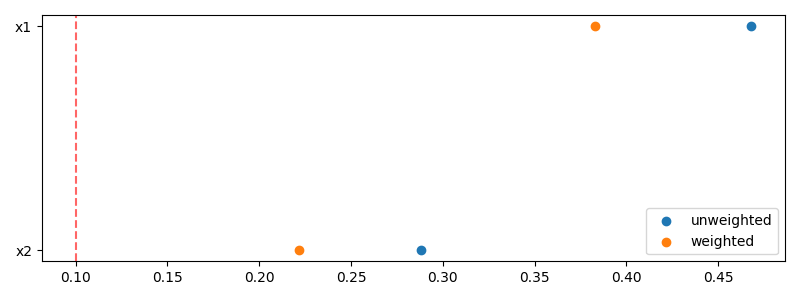

In [12]:
love_path = diag_dir / 'love_plot.png'
plot_love_plot(smd_unweighted, smd_weighted, love_path)
display(Image(filename=str(love_path)))


## 12. Prepare Summary

In [13]:
summary_outputs = [
    source_path,
    metrics_path,
    dr_table_path,
    balance_path,
    if_path,
    prop_path,
    weight_path,
    love_path,
]
artifact_path_for_summary = Path(result.metadata.get('summary_path', OUT_DIR)).parent


## Result Summary

In [14]:
SUMMARY = {
    "uc": UC_ID,
    "executed_at_utc": datetime.now(timezone.utc).isoformat(),
    "status": "passed",
    "artifact_path": str(artifact_path_for_summary),
    "outputs": [str(p) for p in summary_outputs],
    "metrics": metrics_df.round(6).to_dict(orient="records"),
}
(OUT_DIR / "summary.json").write_text(json.dumps(SUMMARY, indent=2), encoding="utf-8")
SUMMARY


{'uc': 'UC-6',
 'executed_at_utc': '2026-02-22T15:10:20.130997+00:00',
 'status': 'passed',
 'artifact_path': '/home/rem/repos/VeldraML/examples/out/phase35_uc06_dr_estimate/artifacts/causal/bfc2b927f57047c8967212dade5e3a93',
 'outputs': ['/home/rem/repos/VeldraML/examples/out/phase35_uc06_dr_estimate/lalonde.csv',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc06_dr_estimate/metrics.csv',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc06_dr_estimate/dr_table.csv',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc06_dr_estimate/balance_smd.csv',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc06_dr_estimate/diagnostics/if_distribution.png',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc06_dr_estimate/diagnostics/propensity_distribution.png',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc06_dr_estimate/diagnostics/weight_distribution.png',
  '/home/rem/repos/VeldraML/examples/out/phase35_uc06_dr_estimate/diagnostics/love_plot.png'],
 'metrics': [{'label': 'dr_att'